In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [73]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [74]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [75]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [143]:
tensor_data = FloatTensor(data.values[:1440],).view(1,1,-1)
tensor_data

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]]])

In [155]:
avg = moving_avg(3,1)
avg_data = avg(tensor_data)
avg_data

tensor([[[22.0437, 22.0456, 22.0459,  ..., 22.0647, 22.0652, 22.0658]]])

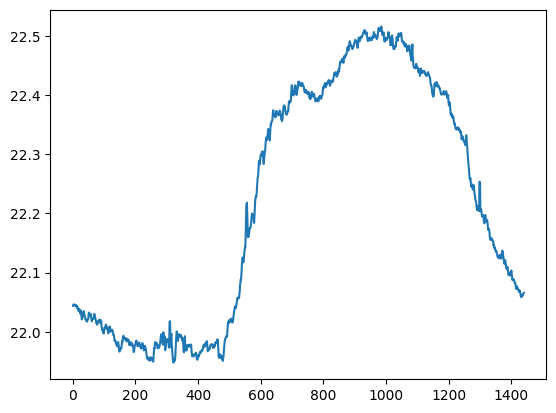

In [156]:
plt.plot(np.arange(1,1441),avg_data.view(-1).numpy()) #plot 데이터 kernel size = 5

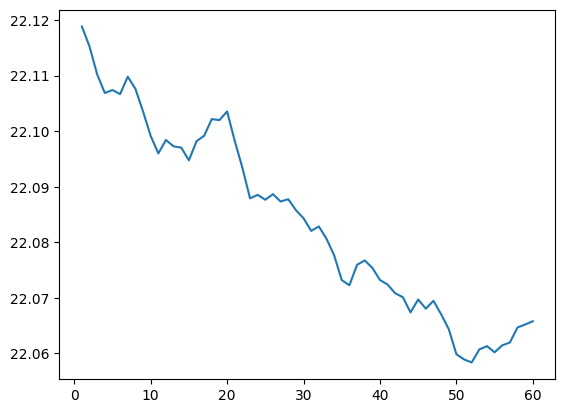

In [157]:
plt.plot(np.arange(1,61),avg_data.view(-1).numpy()[-60:]) #plot 데이터 kernel size = 5

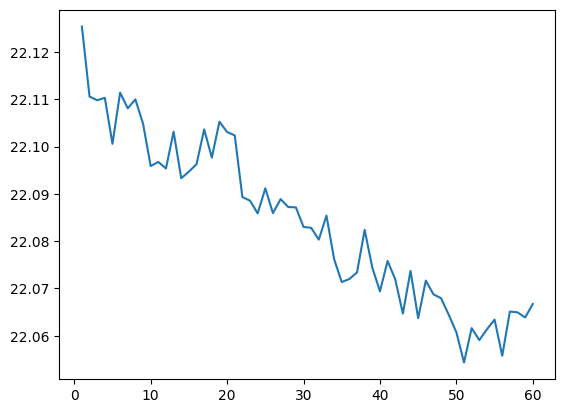

In [158]:
plt.plot(np.arange(1,61),tensor_data.view(-1).numpy()[-60:]) # 원데이터 

In [151]:
decomp = series_decomp(3)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[-0.00213051  0.00240707  0.00131416 ...  0.0003109  -0.00131226
  0.00094986]
[22.04374  22.045593 22.045862 ... 22.064657 22.065193 22.065779]


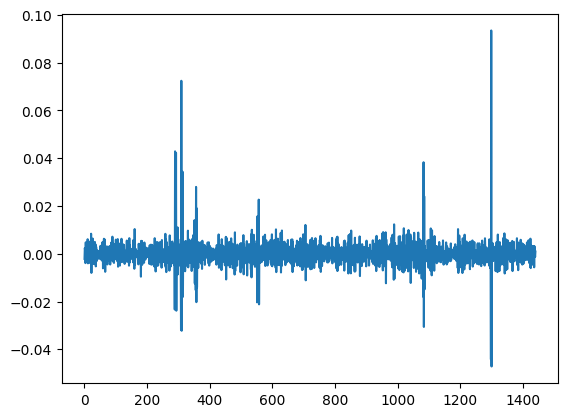

In [152]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

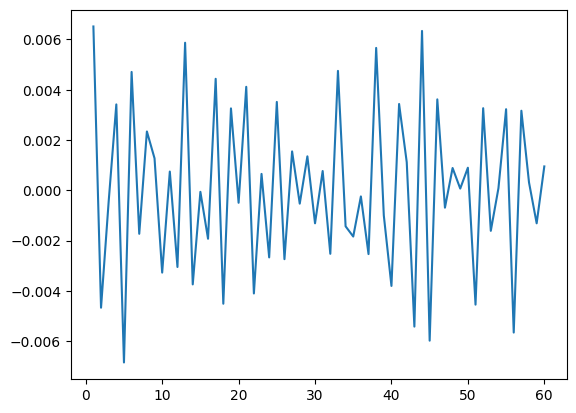

In [154]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

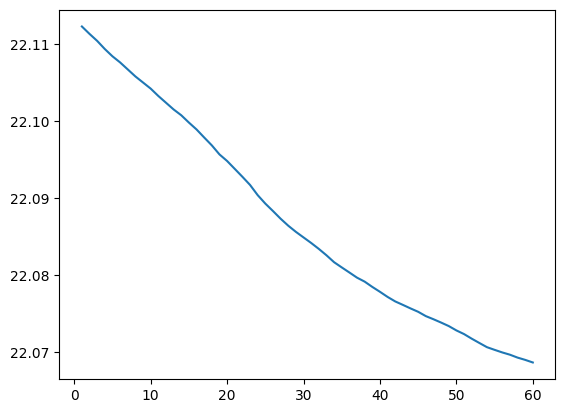

In [169]:
plt.plot(np.arange(1,61),trend_data[-60:])

###########################KernelSize=5######################################

In [201]:
decomp = series_decomp(5)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()# trend data가 곧 moving avg data
print(seasonal_data)
print(trend_data)

[-0.00239182  0.0038414   0.00147247 ...  0.00167274 -0.00160408
  0.00092125]
[22.044    22.044159 22.045704 ... 22.063295 22.065485 22.065807]


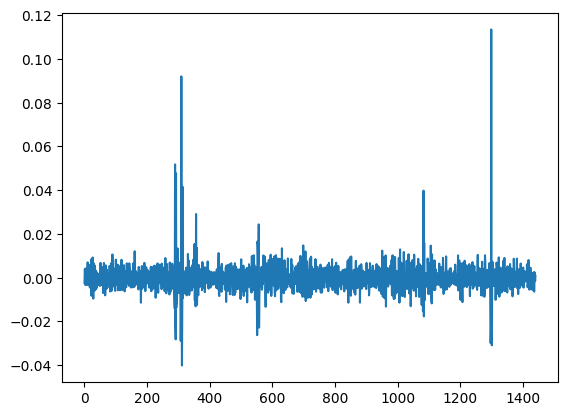

In [202]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

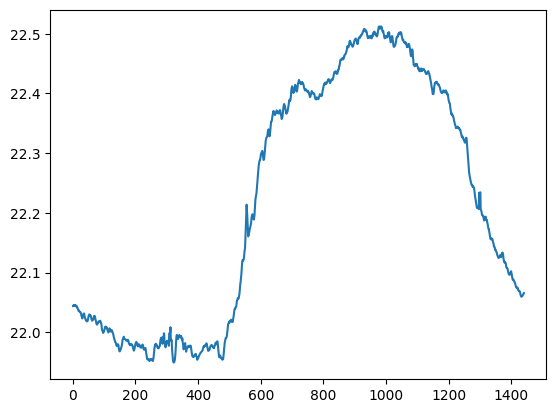

In [203]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 65

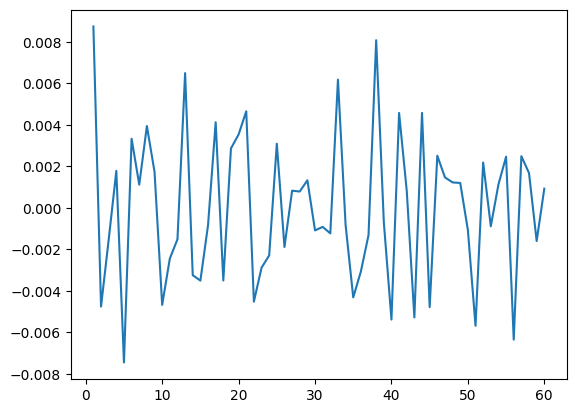

In [204]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

###########################KernelSize=65######################################

In [197]:
decomp = series_decomp(65)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[ 0.00211525  0.00859261  0.00789833 ... -0.00429535 -0.0050869
 -0.00189972]
[22.039494 22.039408 22.039278 ... 22.069263 22.068968 22.068628]


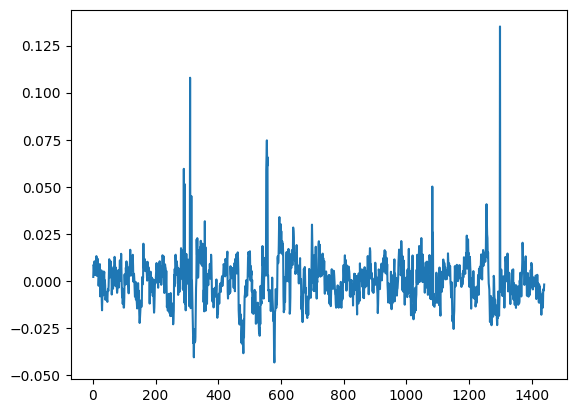

In [198]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 65

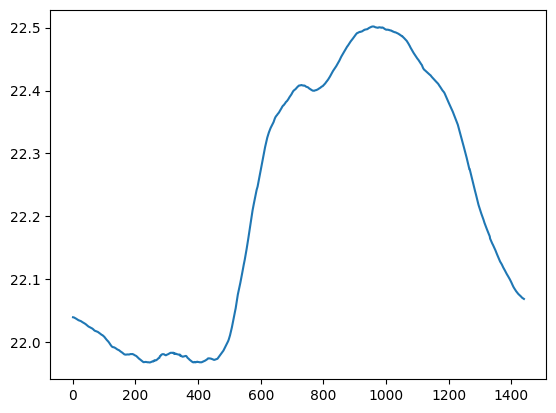

In [199]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 65

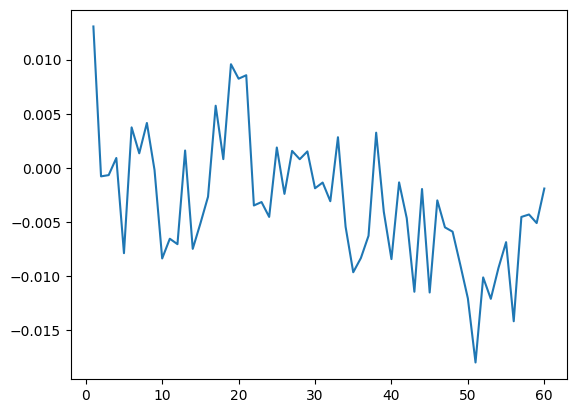

In [179]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

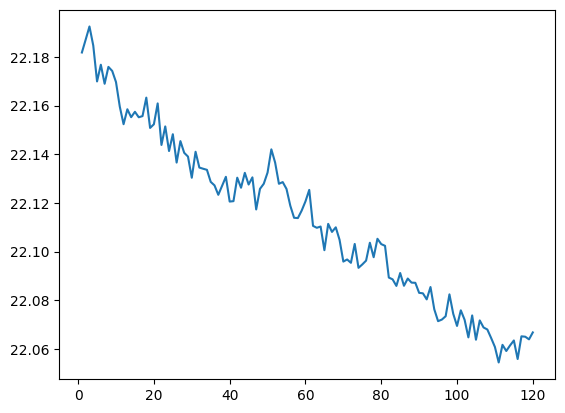

In [180]:
plt.plot(np.arange(1,121),tensor_data.view(-1).numpy()[-120:]) # 원데이터 

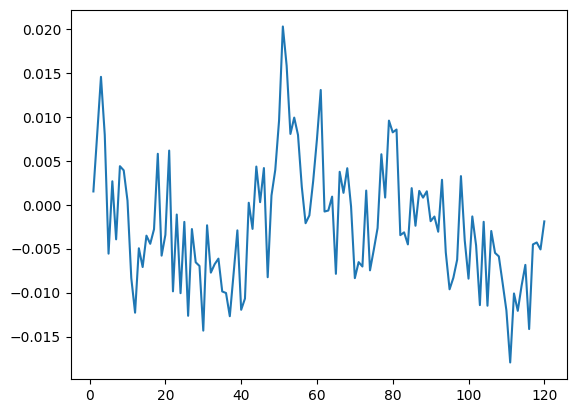

In [181]:
plt.plot(np.arange(1,121),seasonal_data[-120:])

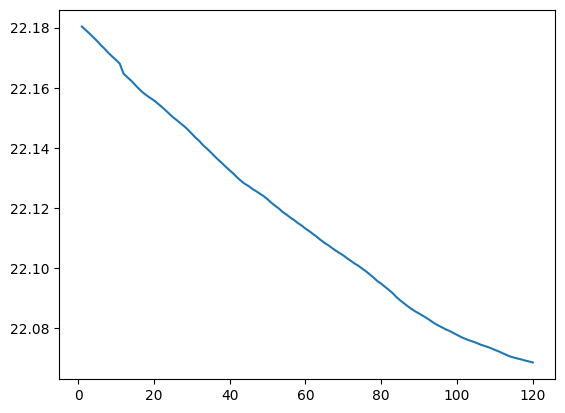

In [182]:
plt.plot(np.arange(1,121),trend_data[-120:])

잘 정제된 seasonality와 덜 정제된 seasonality를 사용해서 좋은 결과를 도출하기를 원한다

###########################KernelSize=1439######################################

In [188]:
decomp = series_decomp(1439)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[-0.01483154 -0.00870895 -0.00979042 ... -0.1527729  -0.15362167
 -0.15052414]
[22.05644  22.05671  22.056967 ... 22.217741 22.217503 22.217253]


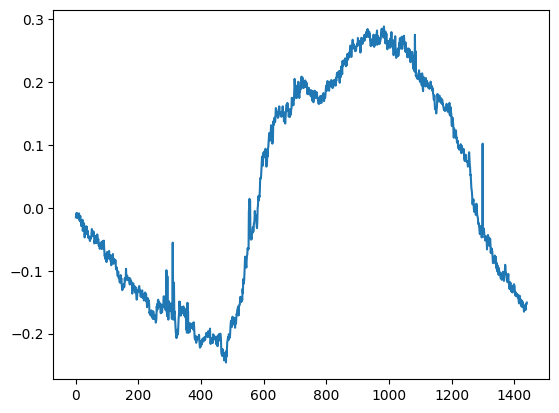

In [189]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

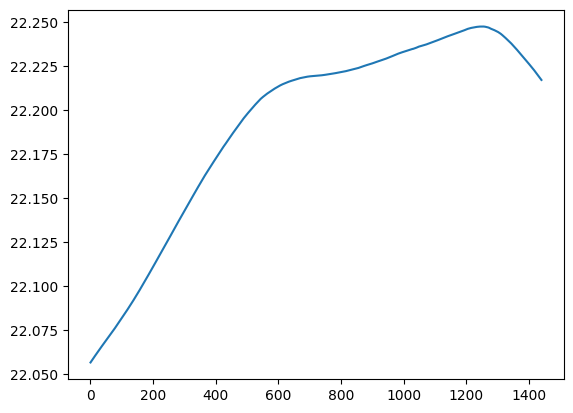

In [195]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 5

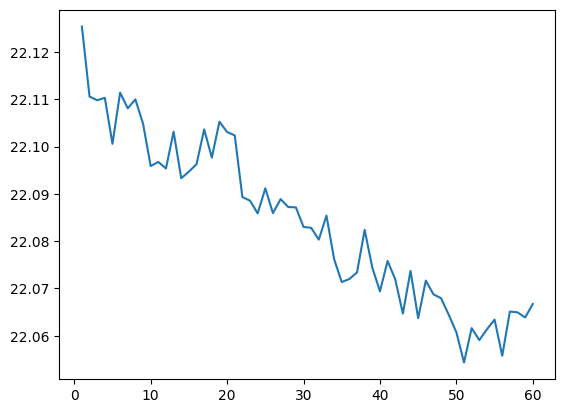

In [194]:
plt.plot(np.arange(1,61),tensor_data.view(-1).numpy()[-60:]) # 원데이터 

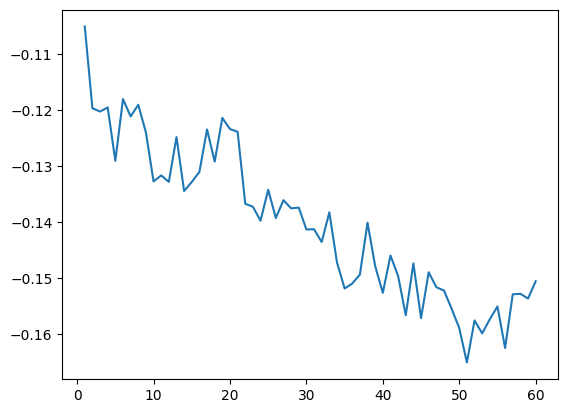

In [190]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

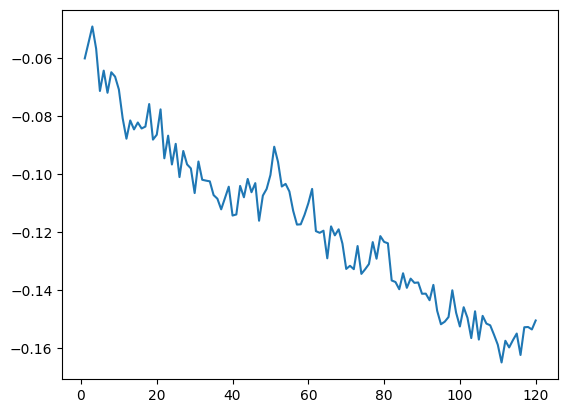

In [191]:
plt.plot(np.arange(1,121),seasonal_data[-120:])

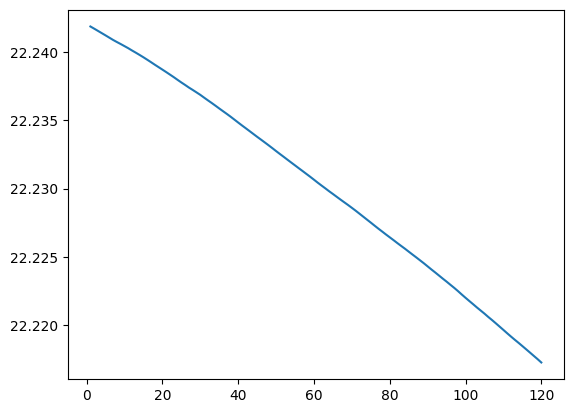

In [192]:
plt.plot(np.arange(1,121),trend_data[-120:])

kernel size를 극단적으로 키우면 padding 되는 값이 그만큼 많아지니깐 moving avg의 변동폭이 작아지게 되고(거의 직선이 되고 따라서 seasonality의 모양이 원데이터를 따라가게 된다